In [125]:
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
import tensorflow as tf
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import import_ipynb
from sklearn.model_selection import GroupShuffleSplit
import numpy_indexed as npi
from scipy import stats
from sklearn.metrics import make_scorer, accuracy_score, precision_score,recall_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
import seaborn as sns
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D,Dropout,Flatten,MaxPooling2D, Input
from tensorflow.keras import optimizers
from tensorflow.keras import utils


In [96]:
path = '/home/josearangos/Documentos/Projects/Voice_Recognition/data/spectrograms/spectrograms_1000.hd5'

In [64]:
df = pd.read_hdf(path)

In [65]:
df

,Spectrogram,speaker,word
0,"[[-5.899411, -6.593098, -21.35734, -21.187449,...",0,4
1,"[[-23.02585, -23.02585, -23.02585, -23.02585, ...",0,4
2,"[[-5.7146406, -6.407505, -20.297499, -20.98756...",1,4
3,"[[-5.8207245, -6.529051, -13.875972, -12.77553...",3,4
4,"[[-5.9325137, -6.628802, -16.829935, -17.02652...",3,4
...,...,...,...
995,"[[-5.8164544, -6.5176325, -15.9848795, -14.700...",114,1
996,"[[-5.7210984, -6.4039636, -15.700572, -17.4116...",114,1
997,"[[-5.596871, -6.3141885, -13.834732, -14.83248...",114,1
998,"[[-6.3125834, -7.004977, -21.878431, -22.00323...",116,1


In [66]:
len(df)

1000

In [67]:
df[:100]

,Spectrogram,speaker,word
0,"[[-5.899411, -6.593098, -21.35734, -21.187449,...",0,4
1,"[[-23.02585, -23.02585, -23.02585, -23.02585, ...",0,4
2,"[[-5.7146406, -6.407505, -20.297499, -20.98756...",1,4
3,"[[-5.8207245, -6.529051, -13.875972, -12.77553...",3,4
4,"[[-5.9325137, -6.628802, -16.829935, -17.02652...",3,4
...,...,...,...
95,"[[-6.1532145, -6.846334, -23.014538, -23.02304...",55,4
96,"[[-6.4018917, -7.0950074, -22.995459, -23.0038...",55,4
97,"[[-6.104321, -6.7975173, -22.981167, -22.83985...",55,4
98,"[[-6.053007, -6.746148, -23.022263, -23.00439,...",55,4


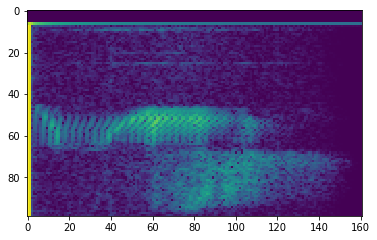

In [68]:
plt.imshow(df.iloc[1,0])

In [115]:
d = np.zeros((len(df),99,161))
c = 0
for i in df['Spectrogram'].values:
    i.reshape((1, 99,161))
    d[c,:,:]=i
    c =c +1

In [111]:
d[0].shape

(99, 161)

In [112]:
d.shape

(1000, 99, 161)

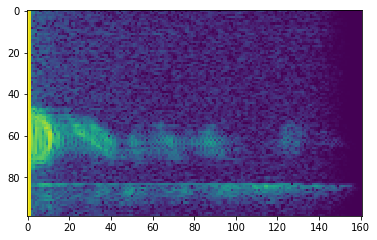

In [72]:
plt.imshow(d[500,:,:])

In [73]:
X = d
Y = df.word.values
print('Tamaño dataSet', X.shape)
print('\n')
Y = np.reshape(Y,(np.size(Y,0),1))
print('Y shape',Y.shape)
groups = df.speaker.values

Tamaño dataSet (1000, 99, 161)


Y shape (1000, 1)


In [74]:
def splitDataSet(X,Y,groups,test_size):              
        gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=0)
        gss.get_n_splits()
        returns = []
        for train_index, test_index in gss.split(X, Y, groups=groups):
            X_train_original, X_test_original = X[train_index], X[test_index]
            Y_train__original, Y_test_original = Y[train_index], Y[test_index]
            groups_original = groups[train_index]
            groups_test_original=groups[test_index]
            returns.append(X_train_original)
            returns.append(Y_train__original)
            returns.append(X_test_original)
            returns.append(Y_test_original)
            returns.append(groups_original)
            returns.append(groups_test_original) 
              
        return returns

In [75]:
data_train = splitDataSet(X,Y,groups,0.2)

In [76]:
X_train_original = data_train[0]
Y_train__original=data_train[1]
X_test_original=data_train[2]
Y_test_original=data_train[3]
groups_original=data_train[4]
groups_test_original=data_train[5]

In [77]:
X_train_original.shape

(776, 99, 161)

In [78]:
Y_test_original.shape

(224, 1)

In [79]:
y_trainOHE = utils.to_categorical(Y_train__original)

In [80]:
y_trainOHE

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [92]:
num_classes = y_trainOHE.shape[1]

In [84]:
input_shape = X_train_original[0].shape
input_shape

(99, 161)

In [100]:
input_shape = (99, 161, 1)

In [129]:
X_train_original= np.expand_dims(X_train_original, axis=3)

In [142]:
X_train_original.shape

(776, 99, 161, 1)

In [143]:
model = Sequential()

img= Input(shape=input_shape)

model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

validity = model(img)

Model(img, validity)

In [144]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 95, 157, 32)       832       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 93, 155, 64)       18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 46, 77, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 226688)            0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               29016192  
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 645       
Total params: 29,036,165
Trainable params: 29,036,165
Non-trainable params: 0
_________________________________________

In [148]:
print("Training...")
history = model.fit(X_train_original, y_trainOHE, epochs=10, batch_size=10, validation_split=0.1, verbose=1)

Training...
Train on 698 samples, validate on 78 samples
Epoch 1/10
698/698 [==============================] - 9s 13ms/sample - loss: 1.5823 - acc: 0.2135 - val_loss: 2.1211 - val_acc: 0.0000e+00
Epoch 2/10
698/698 [==============================] - 9s 13ms/sample - loss: 1.5824 - acc: 0.2006 - val_loss: 2.1371 - val_acc: 0.0000e+00
Epoch 3/10
698/698 [==============================] - 9s 13ms/sample - loss: 1.5824 - acc: 0.2249 - val_loss: 2.1624 - val_acc: 0.0000e+00
Epoch 4/10
698/698 [==============================] - 9s 13ms/sample - loss: 1.5822 - acc: 0.2135 - val_loss: 2.1548 - val_acc: 0.0000e+00
Epoch 5/10
698/698 [==============================] - 9s 13ms/sample - loss: 1.5822 - acc: 0.2120 - val_loss: 2.1749 - val_acc: 0.0000e+00
Epoch 6/10
698/698 [==============================] - 9s 12ms/sample - loss: 1.5824 - acc: 0.2135 - val_loss: 2.1856 - val_acc: 0.0000e+00
Epoch 7/10
698/698 [==============================] - 9s 12ms/sample - loss: 1.5822 - acc: 0.2206 - val_loss:

In [151]:
print(history.history.keys())


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


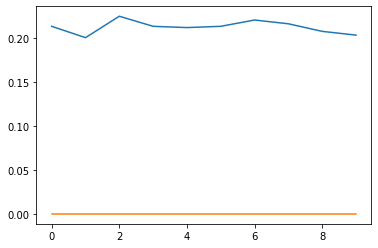

In [152]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()